In [1]:
import os
import numpy as np
import quaternion

import torch
from torch import nn
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
import moviepy.editor as mpy
from IPython import display

## Load Data

In [2]:
# https://github.com/Fyusion/LLFF

def load_poses_bounds_llff(scenedir):
    poses_arr = np.load(os.path.join(scenedir, 'poses_bounds.npy'))
    poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0])
    bds = poses_arr[:, -2:].transpose([1,0])

    # Correct rotation matrix ordering and move variable dim to axis 0
    poses = np.concatenate([poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
    poses = np.moveaxis(poses, -1, 0).astype(np.float32)
    bds = np.moveaxis(bds, -1, 0).astype(np.float32)
    
    hwf = poses[0, :3, -1]
    poses = poses[:, :3, :4]
    
    return poses, bds, hwf

def get_rays_np(H, W, focal, c2w):
    """Get ray origins, directions from a pinhole camera."""
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    #rays_d = np.sum(dirs[..., np.newaxis, :] * np.array([[1,0,0],[0,1,0],[0,0,1]]), -1).astype(np.float32)
    #rays_o = np.broadcast_to(c2w[:3, -1], np.shape(rays_d))
    rays_o = c2w[:3, -1]
    return rays_o, rays_d


def get_x_image(H, W, focal, c2w):
    ro, rd = get_rays_np(H, W, focal, c2w)
    ro = torch.tensor(ro)
    rd = torch.tensor(rd).reshape(-1, 3)
    rd = rd / rd.norm(dim=-1, keepdim=True)
    return ro, rd

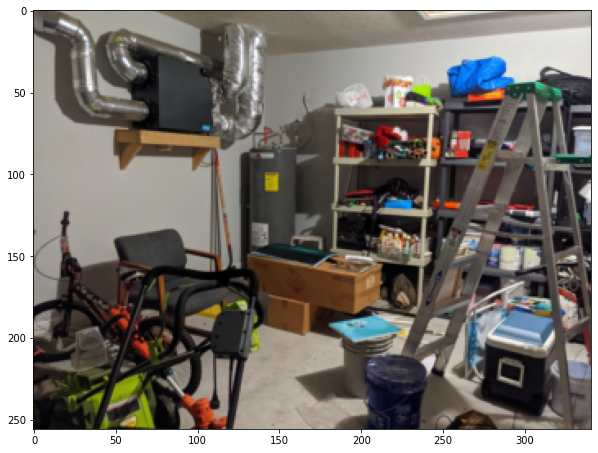

In [3]:
scenedir = '../grodge'

transform=transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])
img_folder = os.path.join(scenedir, 'images')
images = [transform(Image.open(os.path.join(img_folder, v)))
          for v in sorted(os.listdir(img_folder))]
images = torch.stack(images, axis=0)

plt.figure(figsize=(10,)*2)
plt.imshow(images[0].permute(1,2,0))

In [4]:
poses, bds, hwf = load_poses_bounds_llff(scenedir)
print('Camera position mean & std:')
print(poses[:,:,-1].mean(axis=0), poses[:,:,-1].std(axis=0))

H, W = images[0].shape[1:]
focal = H / hwf[0] * hwf[2]

class Data:
    def __init__(self):
        self.origins = []
        self.raydirs = []
        self.colors = []
data = Data()

for i in range(len(poses)):
    ro, rd = get_x_image(H, W, focal, poses[i])
    data.origins.append(ro[None, :])
    data.raydirs.append(rd)
    data.colors.append(images[i].permute(1,2,0).reshape(-1, 3))

data.origins = torch.cat(data.origins, axis=0)
data.raydirs = torch.cat(data.raydirs, axis=0)
data.colors = torch.cat(data.colors, axis=0)

Camera position mean & std:
[0.5587934  0.4400115  0.29173553] [3.122544  2.0582294 0.9369718]


## Define Models

In [5]:
#https://github.com/vsitzmann/siren

class SineLayer(nn.Module):
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

In [6]:
syn_feats = 128
mod_feats = 32
omega_0_syn = 30
omega_0_mod = 0.03
mod_layer = 2 # 0-3

class NVSModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.synth_layers = nn.ModuleList(
            [SineLayer(3, syn_feats, omega_0=omega_0_syn, is_first=True)]
            #+ [SineLayer(syn_feats + mod_feats, syn_feats, omega_0=omega_0_syn) if i == mod_layer
            #   else SineLayer(syn_feats, syn_feats, omega_0=omega_0_syn) for i in range(4)]
            + [SineLayer(syn_feats, syn_feats, omega_0=omega_0_syn) for i in range(4)]
            + [nn.Linear(syn_feats, 3)]
        )
        self.mod_layers = nn.ModuleList(
            [SineLayer(3, mod_feats, omega_0=omega_0_mod, is_first=True)]
            + [SineLayer(mod_feats, mod_feats, omega_0=omega_0_mod) for i in range(2)]
            + [nn.Linear(mod_feats, syn_feats)]
        )
    
    def set_origin(self, origin):
        h = origin[None, :]
        for layer in self.mod_layers:
            h = layer(h)
        self.mod_vec = h
    
    def forward(self, raydirs):
        h = raydirs
        for i, layer in enumerate(self.synth_layers):
            h = layer(h)
            if i == mod_layer:
                #h = torch.cat([h, self.mod_vec.expand(h.shape[0], -1)], axis=-1)
                h = h + self.mod_vec.expand(h.shape[0], -1)
        return h
        

model = NVSModel()
model.cuda()
data.origins = data.origins.cuda()
data.raydirs = data.raydirs.cuda()
data.colors = data.colors.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0006)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.5 ** epoch)

losses = []

## Train

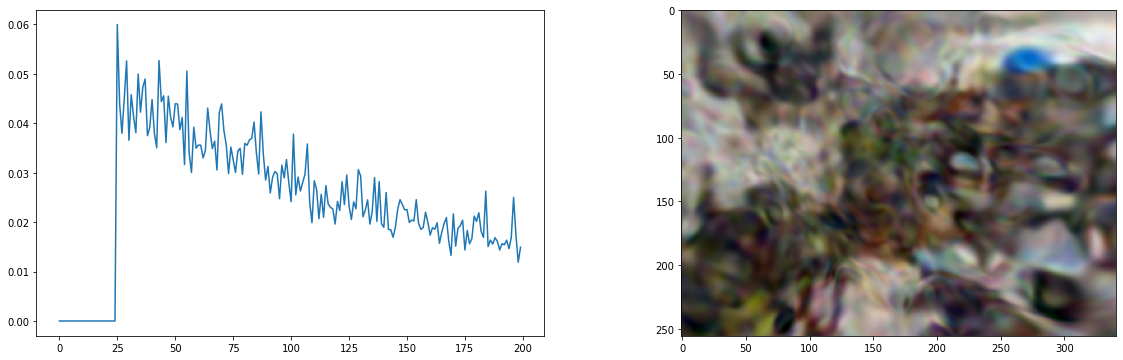

loss: 0.014923060312867165


In [7]:
batch_size = 512

for i in range(2000):
    cam_id = np.random.randint(data.origins.shape[0])
    #cam_id = 4
    model.set_origin(data.origins[cam_id])
    perm = np.random.choice(H * W, batch_size)
    perm += cam_id * H * W
    pred = model(data.raydirs[perm])
    loss = loss_fn(pred, data.colors[perm])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 10 == 0:
        if len(losses) < 25:
            losses.append(0) # cut off high end of plot
        else:
            losses.append(loss.item())
    if (i + 1) % 200 == 0:
        display.clear_output(wait=True)
        plt.figure(figsize=(20, 6))
        plt.subplot(121)
        plt.plot(losses)
        plt.subplot(122)
        with torch.no_grad():
            model.set_origin(data.origins[0])
            x = data.raydirs[:H*W]
            plt.imshow(model(x).detach().clip(0,1).reshape(H, W, 3).cpu())
        plt.show()
    if (i + 1) % 500 == 0:
        scheduler.step()

print(f'loss: {losses[-1]}')

## Test View Interpolation

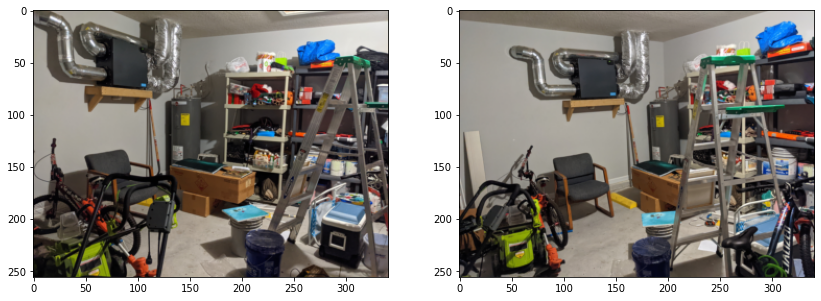

In [8]:
camxs = poses[:, 0, -1]
cam_left_id = np.argmin(camxs)
cam_right_id = np.argmax(camxs) #4
#cam_right_id = 16

q_left = quaternion.from_rotation_matrix(poses[cam_left_id, :, :3])
q_right = quaternion.from_rotation_matrix(poses[cam_right_id, :, :3])

saw = lambda x: 1 - abs(x % 2 - 1)
ease_quad = lambda x: 2 * x**2 if x < 0.5 else 1 - (-2 * x + 2)**2 / 2

def make_frame(t):
    t = ease_quad(saw(t))
    
    a = np.array
    q_t = quaternion.quaternion_time_series.squad(a([q_left, q_right]), a([0, 1]), a([t]))[0]
    #q_t=q_left

    p_left = poses[cam_left_id, :, -1]
    p_right = poses[cam_right_id, :, -1]
    p_t = p_left * (1 - t) + p_right * t
    #p_t=p_left

    pose_t = np.concatenate([quaternion.as_rotation_matrix(q_t), p_t[:, None]], axis=-1).astype('float32')
    
    with torch.no_grad():
        ro, rd = get_x_image(H, W, focal, pose_t)
        ro, rd = ro.cuda(), rd.cuda()
        model.set_origin(ro)
        pred = model(rd)
        pred_r = transforms.Resize(256)(pred.clip(0, 1).reshape(H, W, 3).permute(2,0,1))
        img = pred_r.permute(1,2,0).multiply(255).int().cpu().numpy()
    return img

clip = mpy.VideoClip(make_frame, duration=2)
clip.write_videofile('out.mp4', fps=12)

display.clear_output()
display.display(display.HTML('<video src="out.mp4" controls=true autoplay=true loop=true />'))

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.imshow(images[cam_left_id].permute(1,2,0))
plt.subplot(122)
plt.imshow(images[cam_right_id].permute(1,2,0))